<a href="https://colab.research.google.com/github/rithikkulkarni/Twitter-Sentiment-Stock-Price-Prediction/blob/main/basic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [178]:
# --- Configuration ---
CSV_FILE_PATH = 'https://raw.githubusercontent.com/rithikkulkarni/ALDA-Course-Project/refs/heads/main/datasets/filtered_stocks_test.csv'
TARGET_COLUMN = 'stock_performance'
# TEXT_FEATURE = 'Cleaned_Tweet'
NUMERICAL_FEATURES = ['one_day_price', 'two_day_price', 'three_day_price', 'historical_price'
                          , 'sentiment'
                      ]

TEST_SIZE = 0.2  # 20% of data for testing
RANDOM_STATE = 42 # For reproducibility

In [179]:
df = pd.read_csv(CSV_FILE_PATH)
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)  # Shuffle the DataFrame
print(f"Successfully loaded data. Shape: {df.shape}")
print("\nSample data:")
df.head(1)


print(df['stock_performance'].value_counts())

Successfully loaded data. Shape: (4184, 10)

Sample data:
stock_performance
-1    2171
 1    2013
Name: count, dtype: int64


In [180]:
# This cell gets an equal sample from each label, so we end up with a valid accuracy that isn't inflated from too many of one label

# Find the minimum class count across the classes
min_count = df['stock_performance'].value_counts().min()
print(f"min_count = {min_count}")

# Create a balanced dataframe by sampling min_count instances from each group
df = df.groupby('stock_performance').sample(n=min_count, random_state=42).reset_index(drop=True)

# Sanity check for class balance
print(df['stock_performance'].value_counts())

min_count = 2013
stock_performance
-1    2013
 1    2013
Name: count, dtype: int64


In [181]:
# --- 2. Define Features (X) and Target (y) ---
X = df[NUMERICAL_FEATURES]
y = df[TARGET_COLUMN]

# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
X_train


Training set size: 3220
Test set size: 806


,one_day_price,two_day_price,three_day_price,historical_price,sentiment
274,150.76,152.41,168.17,163.21,0
866,332.17,332.92,328.20,329.74,0
231,369.68,385.62,379.02,368.58,0
2318,134.66,133.50,137.95,135.32,0
2261,166.37,177.66,173.10,231.36,0
...,...,...,...,...,...
1178,333.04,331.33,307.05,283.48,0
1630,124.30,132.57,175.80,170.31,0
454,262.22,258.88,258.74,274.31,0
3582,456.12,448.99,446.42,434.08,0


In [182]:
# --- 5. Choose and Define the Model ---
# Using RandomForestClassifier as an example. It often works well with mixed data.
# You can adjust n_estimators, max_depth, etc., or try other models.
# class_weight='balanced' can help if your classes (-1, 0, 1) are imbalanced.
#model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)

# Alternative: Logistic Regression (often faster, good baseline)
model = LogisticRegression(multi_class='ovr', solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)

print("\nTraining the model...")
model.fit(X_train, y_train)
# importances = model.feature_importances_
coefficients = model.coef_[0]
print("Model training complete.")

# --- 7. Make Predictions ---
print("\nMaking predictions on the test set...")
y_pred = model.predict(X_test)

# --- 8. Evaluate the Model ---
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")


print("\nClassification Report:")
# Use labels=[-1, 0, 1] to ensure all classes are shown even if one is missing in predictions
# zero_division=0 handles cases where precision/recall might be zero for a class
print(classification_report(y_test, y_pred, labels=[-1, 0, 1], target_names=['Down (-1)', 'Neutral (0)', 'Up (1)'], zero_division=0))

print("\nConfusion Matrix:")
# Rows: Actual, Columns: Predicted
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
print(pd.DataFrame(cm, index=['Actual Down', 'Actual Neutral', 'Actual Up'],
                   columns=['Predicted Down', 'Predicted Neutral', 'Predicted Up']))
print(coefficients)



Training the model...
Model training complete.

Making predictions on the test set...

--- Model Evaluation ---
Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

   Down (-1)       0.50      0.58      0.54       403
 Neutral (0)       0.00      0.00      0.00         0
      Up (1)       0.50      0.42      0.46       403

    accuracy                           0.50       806
   macro avg       0.33      0.33      0.33       806
weighted avg       0.50      0.50      0.50       806


Confusion Matrix:
                Predicted Down  Predicted Neutral  Predicted Up
Actual Down                234                  0           169
Actual Neutral               0                  0             0
Actual Up                  234                  0           169
[ 0.00139276  0.00119582 -0.0018998  -0.00064757 -0.04529134]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [158]:
# prompt: i now need a cell to predict a column called pct_change instead of stock_performance. the issue is that pct_change is a float instead of just being -1 0 or 1, so im not sure what model to use

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Use a regressor for float target
from sklearn.metrics import mean_squared_error, r2_score

# ... (Previous code remains the same)

# --- 2. Define Features (X) and Target (y) ---
X = df[NUMERICAL_FEATURES]
y = df['pct_change']  # Target is now 'pct_change'

# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
    # No need for stratify with regression
)

# --- 5. Choose and Define the Model ---
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
print("\nTraining the model...")
model.fit(X_train, y_train)
print("Model training complete.")

# --- 7. Make Predictions ---
print("\nMaking predictions on the test set...")
y_pred = model.predict(X_test)

# --- 8. Evaluate the Model ---
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"\n--- Model Evaluation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
importances = model.feature_importances_
print(importances)



Training the model...
Model training complete.

Making predictions on the test set...

--- Model Evaluation ---
Mean Squared Error (MSE): 11.0143
Root Mean Squared Error (RMSE): 3.3188
R-squared (R2): -0.1418
[0.23849623 0.22774791 0.25248235 0.28127352]


In [65]:
df.head(10)

,Date,Stock Name,sentiment,stock_performance,pct_change,one_day_price,two_day_price,three_day_price,historical_price
0,2021-10-08,PYPL,0.807400,-1,-1.926476,263.54,264.06,260.15,272.37
1,2021-12-30,NIO,0.255063,-1,-2.282535,28.25,29.63,29.96,32.28
2,2021-12-08,ENPH,0.153100,-1,-4.104426,222.56,212.94,217.10,244.44
3,2022-06-10,GOOG,-0.503500,-1,-4.084266,114.38,116.69,116.68,112.75
4,2021-11-11,TSLA,0.247311,-1,-2.829310,355.98,341.17,387.65,337.20
5,2021-10-15,BA,0.434625,-1,-0.027644,217.44,221.78,223.57,220.35
6,2022-03-22,DIS,-0.093650,-1,-1.762916,136.93,138.59,137.77,138.53
7,2022-09-19,TSLA,0.188130,-1,-0.110006,303.35,303.75,302.61,289.81
8,2021-12-07,COST,0.459800,-1,-2.197340,510.44,506.35,503.08,506.22
9,2022-08-16,INTC,0.476700,-1,-1.132904,34.57,34.36,33.86,35.45


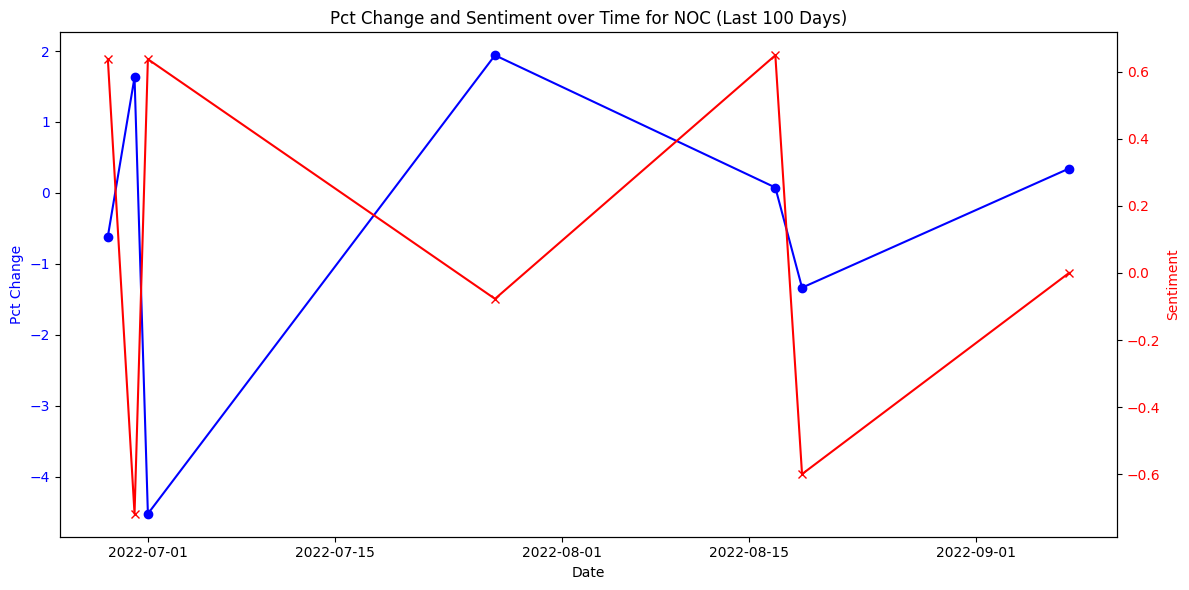

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# Parameters: specify the company and number of days
company_name = "NOC"
n = 100  # Number of days to plot

# Filter the DataFrame for the selected company
df_company = df[df["Stock Name"] == company_name].copy()

# Ensure the Date column is in datetime format and sort the data by date
df_company["Date"] = pd.to_datetime(df_company["Date"])
df_company.sort_values("Date", inplace=True)

# Filter the data to include only the last n days (based on calendar days)
end_date = df_company["Date"].max()
start_date = end_date - pd.Timedelta(days=n - 1)
df_plot = df_company[(df_company["Date"] >= start_date) & (df_company["Date"] <= end_date)]

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot pct_change on the primary y-axis
ax1.plot(df_plot["Date"], df_plot["pct_change"], color="blue", marker="o", label="Pct Change")
ax1.set_xlabel("Date")
ax1.set_ylabel("Pct Change", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a secondary y-axis for sentiment
ax2 = ax1.twinx()
ax2.plot(df_plot["Date"], df_plot["sentiment"], color="red", marker="x", label="Sentiment")
ax2.set_ylabel("Sentiment", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add title and format x-axis labels for readability
plt.title(f"Pct Change and Sentiment over Time for {company_name} (Last {n} Days)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [67]:
from scipy.stats import pearsonr, spearmanr

# Compute Pearson correlation for the filtered data (for the given company)
pearson_corr, pearson_p = pearsonr(df_plot['pct_change'], df_plot['sentiment'])
print(f"Pearson correlation for {company_name}: {pearson_corr:.4f}, p-value: {pearson_p:.4e}")

# Compute Spearman correlation for the filtered data (for the given company)
spearman_corr, spearman_p = spearmanr(df_plot['pct_change'], df_plot['sentiment'])
print(f"Spearman correlation for {company_name}: {spearman_corr:.4f}, p-value: {spearman_p:.4e}")


Pearson correlation for TSM: 0.1581, p-value: 2.0142e-01
Spearman correlation for TSM: 0.1169, p-value: 3.4619e-01


In [79]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Get the unique companies from the "Stock Name" column
companies = df["Stock Name"].unique()

# List to store correlation results for each company
results = []

# Loop through each company
for company in companies:
    # Filter the DataFrame for the current company
    company_data = df[df["Stock Name"] == company]

    # Check if there are enough data points to compute correlations
    if len(company_data) > 1:
        try:
            # Compute Pearson correlation (linear relationship)
            pearson_corr, pearson_p = pearsonr(company_data["pct_change"], company_data["sentiment"])
            # Compute Spearman correlation (monotonic relationship)
            spearman_corr, spearman_p = spearmanr(company_data["pct_change"], company_data["sentiment"])
        except Exception as e:
            # If any error occurs, set values to None
            pearson_corr, pearson_p, spearman_corr, spearman_p = None, None, None, None
    else:
        pearson_corr, pearson_p, spearman_corr, spearman_p = None, None, None, None

    # Append the results for the current company as a dictionary
    results.append({
        "Stock Name": company,
        "Pearson Corr": pearson_corr,
        "Pearson p-value": pearson_p,
        "Spearman Corr": spearman_corr,
        "Spearman p-value": spearman_p
    })

# Create a new DataFrame from the results
df_corr = pd.DataFrame(results)
# print(df_corr)

# Sort by absolute value of Pearson or Spearman correlation
df_corr_sorted = df_corr.sort_values(by="Pearson Corr", key=lambda x: x.abs(), ascending=False)
print(df_corr_sorted)

# Only show correlations where p-value is below 0.05
# significant_corrs = df_corr[(df_corr["Pearson p-value"] < 0.05) | (df_corr["Spearman p-value"] < 0.05)]
# print(significant_corrs)





   Stock Name  Pearson Corr  Pearson p-value  Spearman Corr  Spearman p-value
24        NOC     -0.315333         0.133371      -0.309068          0.141684
14          F     -0.313468         0.145252      -0.326067          0.128912
23         VZ     -0.181201         0.162249      -0.185847          0.151569
5          BA      0.156347         0.059495       0.095380          0.252131
4        TSLA     -0.123216         0.053596      -0.116172          0.068917
2        ENPH     -0.121669         0.261600      -0.007074          0.948149
3        GOOG      0.120073         0.068509       0.112840          0.087048
21         ZS     -0.113347         0.266454      -0.034768          0.733955
22       XPEV      0.094449         0.375899       0.075185          0.481248
7        COST     -0.083312         0.314086      -0.095211          0.249697
17        CRM     -0.058009         0.547197      -0.078213          0.416689
10         KO     -0.057881         0.513036      -0.089044     

In [ ]:
import statsmodels.api as sm

# Define the predictor variables and the target variable.
# You can adjust the features list to include any factors you wish to control for.
features = ['sentiment', 'one_day_price', 'two_day_price', 'three_day_price', 'historical_price']
X = df_plot[features]
y = df_plot['pct_change']

# Add a constant to the predictors (for the intercept)
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             pct_change   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1.752
Date:                Mon, 07 Apr 2025   Prob (F-statistic):              0.136
Time:                        21:10:13   Log-Likelihood:                -139.80
No. Observations:                  67   AIC:                             291.6
Df Residuals:                      61   BIC:                             304.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.1019      7.755  